# Predicting House Sale Prices using Linear Regression model #

In this project, we'll work with the `AmesHousing` data collected by Dean De Cock, describing the sale of individual residential property in Ames, Iowa from 2006 to 2010.

Our goal is to find the lowest Root Mean Squared Error, using linear regression model with feature selection and feature engineering.

The data `AmesHousing.txt` can be found [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) and the documentation about columns can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## Reading the data

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error



house = pd.read_csv('AmesHousing.txt', delimiter='\t')
house.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Building train and test functions ##

We are comparing the result with and without feature engineering to see how important to include that method in our work.

In the on hand, we will built a default model without feature engineering...

In [2]:
### create a function that return data set
def transform_features(df):
    return df

### create a function that returns the 'Gr Liv Area' and 'SalePrice' columns from the data frame
def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

### create a model-building function
def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    
    # return only nemerical columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    # split feature columns and target column
    features = numeric_train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    # build the model
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    
    # return the RMSE value
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    return rmse

transform_house = transform_features(house)
filtered_house = select_features(transform_house)
RMSE = train_and_test(filtered_house)
RMSE

57088.25161263909

The RMSE given by the model without feature engineering is **57088.25**.

## Feature engineering ##

In the other hand, we are including feature engineering into the model. But to figure out how to modify the function we built, we need to add some preliminary steps.

Let's start to removing features with many missing values, diving deeper into potential categorial features, and transforming text and numerical columns.

**Firstly**, let's drop the columns contain more than 5% missing values.
- For text column, drop any with 1 or more missing values.
- For numerical column that meet the criteria, fill the missing value with the most popular value in that column;

Drop the columns that contain more than 5% missing values

In [3]:
null_values = house.isnull().sum()
big_count = null_values[null_values > (len(house) * 0.05)].sort_values()
house = house.drop(big_count.index, axis=1)

For text column, drop any containing 1 or more missing values

In [4]:
text_missing = house.select_dtypes(include=['object']).isnull().sum()
drop_missing = text_missing[text_missing > 0]
house = house.drop(drop_missing.index, axis=1)

For numerical column that, fill the missing values with the most popular value for that column

In [5]:
numeric_missing = house.select_dtypes(include=['int64', 'float64']).isnull().sum()
numeric_to_fix = numeric_missing[numeric_missing > 0]
numeric_to_fix

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [6]:
# compute the moste common value for each column in 'numeric_to_fix'
fix_dict = house[numeric_to_fix.index].mode().to_dict(orient='index')[0]
fix_dict

{'Mas Vnr Area': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [7]:
# replace missing values
house = house.fillna(fix_dict)

# verify that we have a full data set
house.isnull().sum().value_counts()

0    64
dtype: int64

**Secondly**, let's create new features that better capture the information in some of the old ones.

The 3 new features we are creating are `Year Before Sale`, `Year Until Remod` and `Year Since Remod`.

In [8]:
house['Year Before Sale'] = house['Yr Sold'] - house['Year Built']
house['Year Before Sale'][house['Year Before Sale'] < 0]

2180   -1
Name: Year Before Sale, dtype: int64

In [9]:
house['Year Since Remod'] = house['Yr Sold'] - house['Year Remod/Add']
house['Year Since Remod'][house['Year Since Remod'] < 0]

1702   -1
2180   -2
2181   -1
Name: Year Since Remod, dtype: int64

In [10]:
# drop rows that contains negative value, which is not logic in reality
house = house.drop(house.index[[850, 1702, 2180, 2181]])

# drop original year columns that are no longer needed
house = house.drop(['Year Built', 'Yr Sold','Year Remod/Add'], axis=1)

**Finally**, let's remove the columns that:
- aren't useful for Machine Learning: `PID`, `Order`;
- leak data about the final sale: `Mo Sold`, `Sale Condition`, `Sale Type`, `Yr Sold`.

In [11]:
# 'Yr Sold' is already dropped above
house = house.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type'], axis=1)

**Now, let's update the `transform_features()` function, based on what we have done in the steps above.**

In [12]:
### rebuild this function, including feature engineering
def transform_features(df):
    # dropping columns that have missing values > 5% 
    null_values = df.isnull().sum()
    big_count = null_values[null_values > (len(df) * 0.05)].sort_values()
    df = df.drop(big_count.index, axis=1)
    
    # cleaning text columns
    text_missing = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing = text_missing[text_missing > 0]
    df = df.drop(drop_missing.index, axis=1)
    
    # cleaning numerical columns
    numeric_missing = df.select_dtypes(include=['integer', 'float']).isnull().sum()
    numeric_to_fix = numeric_missing[numeric_missing > 0]
    fix_dict = df[numeric_to_fix.index].mode().to_dict(orient='index')[0]
    df = df.fillna(fix_dict)
    
    # creating new columns and dropping no longer needed columns
    df['Year Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Year Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop(house.index[[1702, 2180, 2181]])
    df = df.drop(['Year Built', 'Year Remod/Add', 'Yr Sold'], axis=1)
    
    # removing also other irrelevant columns
    df = df.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type'], axis=1)
    
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    
    # return only nemerical columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    # split feature columns and target column
    features = numeric_train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    # build the model
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    
    # return the RMSE value
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    return rmse

new_house = pd.read_csv('AmesHousing.txt', delimiter='\t')

transform_house = transform_features(new_house)
filtered_house = select_features(transform_house)
RMSE = train_and_test(filtered_house)
RMSE

57081.488466690316

The RMSE given by the model with feature engineering is **57081.49**, which is lower than the last RMSE given by the model without feature engineering, 57088.25.

## Feature Selection ##

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on  to feature selection for numerical features.

In [13]:
# find the correlations between features columns and the 'SalePrice' column
numeric_house = house.select_dtypes(include=['integer', 'float'])
correlations = numeric_house.corr()['SalePrice'].abs().sort_values()
correlations

BsmtFin SF 2        0.006156
Misc Val            0.019264
3Ssn Porch          0.032279
Bsmt Half Bath      0.035852
Low Qual Fin SF     0.037620
Pool Area           0.068445
MS SubClass         0.085056
Overall Cond        0.101498
Screen Porch        0.112310
Kitchen AbvGr       0.119743
Enclosed Porch      0.128656
Bedroom AbvGr       0.143902
Bsmt Unf SF         0.182862
Lot Area            0.267517
2nd Flr SF          0.269707
Bsmt Full Bath      0.276214
Half Bath           0.284974
Open Porch SF       0.316277
Wood Deck SF        0.328158
BsmtFin SF 1        0.439365
Fireplaces          0.474994
TotRms AbvGrd       0.498614
Mas Vnr Area        0.507010
Year Since Remod    0.534972
Full Bath           0.546108
Year Before Sale    0.558984
1st Flr SF          0.635183
Garage Area         0.641414
Total Bsmt SF       0.644023
Garage Cars         0.648351
Gr Liv Area         0.717617
Overall Qual        0.801212
SalePrice           1.000000
Name: SalePrice, dtype: float64

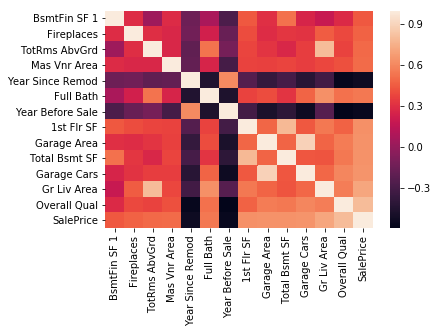

In [14]:
# Let's keep features that have correlations > 0.3
strong_corr = correlations[correlations > 0.4]
corrmat = house[strong_corr.index].corr()

# generate a correlation heatmap matrix
import seaborn as sns
sns.heatmap(corrmat)

From the heatmap, we can see many pairs of strongly-correlated features:
- `Gr Liv Area` and `TotRms AbvGrd`.
- `Garage Cars` and `Garage Area`.
- `Total Bsmt SF` and `1st Flr SF`.

There is a potential collinearity between these feature columns and it stands the risk of duplicating information. Thanks to the documentation, we can see that each of the first two pairs of columns reflect very similar information. For the last pair, however, we can tell that most basements have their 1st floor, and it is the most important part of a house, so it's very clear to see a highly strong correlation between first floor square feet and total basement square feet.

Consequently, we will remove `TotRms AbvGrd`, `Garage Cars` since the others elements in the pairs are continuous variables that capture more nuance. For the last pair, we want to keep them both.

Ultimately, we will drop the columns that have low correlation with `SalePrice` as well (under 0.4) 

In [15]:
house = house.drop(['TotRms AbvGrd', 'Garage Cars'], axis=1)

low_corr = correlations[correlations < 0.4]
house = house.drop(low_corr.index, axis=1)

Now, it's time to deal with categorical columns. Which one should we keep ?

In [16]:
# create a list of column names from documentation that are supposed to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

# let's see we have how many features left after doing feature engineering from the beginning of the project
remained_nominal = []
for col in nominal_features:
    if col in house.columns:
        remained_nominal.append(col)

remained_nominal

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

In [17]:
# how many unique values in each categorical column ?
unique_counts = house[remained_nominal].apply(lambda x: len(x.value_counts())).sort_values()
unique_counts

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

We would keep only any column that has under 10 unique values to avoid bad dummy coding.

In [18]:
drop_cols = unique_counts[unique_counts > 10].index
house = house.drop(drop_cols, axis=1)

In [19]:
# Convert the remaining text columns to categorical
text_cols = house.select_dtypes(include=['object'])
for col in text_cols:
    house[col] = house[col].astype('category')
    
# Dummy coding and remove original category columns
house = pd.concat([
    house,
    pd.get_dummies(house.select_dtypes(include=['category']))
], axis=1).drop(text_cols, axis=1)

**Great! Let's go update the `selection_features()` function !**

## Final step: Upgrade the whole model ##

In [41]:
### rebuild this function, including feature engineering
def transform_features(df):
    null_values = df.isnull().sum()
    big_count = null_values[null_values > (len(df) * 0.05)].sort_values()
    df = df.drop(big_count.index, axis=1)
   
    text_missing = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing = text_missing[text_missing > 0]
    df = df.drop(drop_missing.index, axis=1)
    
    numeric_missing = df.select_dtypes(include=['integer', 'float']).isnull().sum()
    numeric_to_fix = numeric_missing[numeric_missing > 0]
    fix_dict = df[numeric_to_fix.index].mode().to_dict(orient='index')[0]
    df = df.fillna(fix_dict)

    df['Year Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Year Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop(house.index[[1702, 2180, 2181]])
    df = df.drop(['Year Built', 'Year Remod/Add', 'Yr Sold'], axis=1)
  
    df = df.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type'], axis=1)
    
    return df


def select_features(df, coeff_threshold=0.4, unique_threshold=10):
    numeric_house = df.select_dtypes(include=['integer', 'float'])
    correlations = numeric_house.corr()['SalePrice'].abs().sort_values()
    low_corr = correlations[correlations < coeff_threshold]
    df = df.drop(low_corr.index, axis=1)
    df = df.drop(['TotRms AbvGrd', 'Garage Cars'], axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

    remained_nominal = []
    for col in nominal_features:
        if col in df.columns:
            remained_nominal.append(col)
    
    unique_counts = df[remained_nominal].apply(lambda x: len(x.value_counts())).sort_values()
    drop_cols = unique_counts[unique_counts > unique_threshold].index
    df = df.drop(drop_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    
    df = pd.concat([
                        df,
                        pd.get_dummies(df.select_dtypes(include=['category']))
                      ], axis=1).drop(text_cols, axis=1)

    return df

# add a parameter "k" that controls the type of cross validation that occurs
def train_and_test(df, k=0):
    features = df.select_dtypes(include=['integer', 'float']).columns.drop('SalePrice')
    target = 'SalePrice'
    lr = LinearRegression()
    
    if k == 0:
        train = df[0:1460]
        test = df[1460:]
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test[target], predictions))
        return rmse
    
    if k == 1:
        random_df = df.sample(frac=1)
        fold_one = random_df[0:1460]
        fold_two = random_df[1460:]
        
        lr.fit(fold_one[features], fold_one[target])
        predictions_one = lr.predict(fold_two[features])
        rmse_one = np.sqrt(mean_squared_error(fold_two[target], predictions_one))
        
        lr.fit(fold_two[features], fold_two[target])
        predictions_two = lr.predict(fold_one[features])
        rmse_two = np.sqrt(mean_squared_error(fold_one[target], predictions_two))
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            rmse = np.sqrt(mean_squared_error(test[target], predictions))
            rmse_values.append(rmse)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
        
df = pd.read_csv('AmesHousing.txt', delimiter='\t')

transform_df = transform_features(df)
filtered_df = select_features(transform_df)

k_rmses = {}
for n in range(0,10):
    rmse = train_and_test(filtered_df, k=n)
    k_rmses[n] = rmse

k_rmses

{0: 38043.13376108408,
 1: 34539.89326660787,
 2: 32685.97691839924,
 3: 31709.4788883109,
 4: 33414.18841444694,
 5: 31398.828756448813,
 6: 31314.7142845341,
 7: 31590.128948154517,
 8: 30818.485620949727,
 9: 31211.80336761567}

In [44]:
ideal_k = min(k_rmses, key=k_rmses.get)
ideal_k

8

For the cross validation, we can get the low RMSE at **30818.49** with k-fold = 8.

# Conclusion #

When training and testing the model without feature engineering and feature selection, we got a RMSE = **57088**.

When including feature engineering, we got a lower RMSE = **57081.5**.

When including feature engineering, feature selection and adding a k-fold for cross validation, we got a lowest RMSE = **30818.5** with **k = 8**.

The more highly the data is prepared and transformed, the better the RMSE is.